## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import chain
##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import sklearn.model_selection as skl
import random
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from sklearn import metrics
# from sklearn.metrics import f1_score

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
65820,00016249_002.png,Pneumothorax,2,16249,51,M,AP,2500,2048,0.168,0.168,NaN,/data/images_008/images/00016249_002.png
105320,00028290_002.png,No Finding,2,28290,70,F,AP,3056,2544,0.139,0.139,NaN,/data/images_012/images/00028290_002.png
17740,00004798_006.png,No Finding,6,4798,32,F,PA,2992,2991,0.143,0.143,NaN,/data/images_003/images/00004798_006.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
print(all_labels)

for c_label in all_labels:
    if len(c_label)>1: # leave out empty labels
        all_xray_df[c_label] = all_xray_df['Finding Labels'].map(lambda finding: 1 if c_label in finding else 0)
all_xray_df.sample(3)
# Todo

['Atelectasis' 'Cardiomegaly' 'Consolidation' 'Edema' 'Effusion'
 'Emphysema' 'Fibrosis' 'Hernia' 'Infiltration' 'Mass' 'No Finding'
 'Nodule' 'Pleural_Thickening' 'Pneumonia' 'Pneumothorax']


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Emphysema,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax
53170,00013424_000.png,Infiltration,0,13424,56,M,PA,2992,2991,0.143,...,0,0,0,1,0,0,0,0,0,0
73400,00018055_018.png,Atelectasis|Pneumothorax,18,18055,64,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,0,0,1
17924,00004822_028.png,Infiltration,28,4822,26,M,PA,2048,2500,0.168,...,0,0,0,1,0,0,0,0,0,0


In [4]:
## Here we can create a new column called 'pneumonia_class' that will allow us to look at 
## images with or without pneumonia for binary classification

all_xray_df['pneumonia_class'] = all_xray_df['Pneumonia'].replace({0:'Negative', 1:'Positive'})
all_xray_df[all_xray_df['pneumonia_class']== 'Positive']

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,1,Positive
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,1,0,Positive
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0,0,0,0,0,1,0,1,0,Positive
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139,...,0,0,1,0,0,0,1,1,0,Positive
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,0,Positive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111557,00030536_007.png,Atelectasis|Consolidation|Pneumonia,7,30536,56,F,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,0,Positive
111627,00030570_001.png,Edema|Infiltration|Pneumonia,1,30570,29,F,AP,3056,2544,0.139,...,0,0,1,0,0,0,0,1,0,Positive
111767,00030621_002.png,Pneumonia,2,30621,22,F,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,0,Positive
111845,00030637_016.png,Consolidation|Pneumonia,16,30637,48,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,0,Positive


## Create your training and testing data:

In [5]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    
    # Todo
    train_df, valid_df = skl.train_test_split(df, 
                                   test_size = 0.2, 
                                   stratify = df['Pneumonia'])
    
    #To have _EQUAL_ amount of positive and negative cases of Pneumothorax in Training 
    p_inds = train_df[train_df.Pneumonia==1].index.tolist()
    np_inds = train_df[train_df.Pneumonia==0].index.tolist()

    np_sample = random.sample(np_inds,len(p_inds))
    train_data = train_df.loc[p_inds + np_sample]
    
    
    p_inds = valid_df[valid_df.Pneumonia==1].index.tolist()
    np_inds = valid_df[valid_df.Pneumonia==0].index.tolist()

    # The following code pulls a random sample of non-pneumonia data that's 4 times as big as the pneumonia sample.
    np_sample = random.sample(np_inds,4*len(p_inds))
    val_data = valid_df.loc[p_inds + np_sample]

    return train_data, val_data



# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [6]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.5) ## Here I'm adding a lot more zoom 


    return idg


def make_train_gen(df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=None, 
#                                          x_col = ,
#                                          y_col = ,
#                                          class_mode = 'binary',
#                                          target_size = , 
#                                          batch_size = 
#                                          )
     # Todo
    idg = my_image_augmentation()
    train_gen = idg.flow_from_dataframe(dataframe=df, 
                                 directory=None, 
                                 x_col = 'path',
                                 y_col = 'pneumonia_class',
                                 class_mode = 'binary',
                                 target_size = IMG_SIZE, 
                                 batch_size = BATCH_SIZE
                                 )
    return train_gen


def make_val_gen(df):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=None, 
#                                              x_col = ,
#                                              y_col = ',
#                                              class_mode = 'binary',
#                                              target_size = , 
#                                              batch_size = ) 
    
    # Todo
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    val_gen = val_idg.flow_from_dataframe(dataframe=df, 
                             directory=None, 
                             x_col = 'path',
                             y_col = 'pneumonia_class',
                             class_mode = 'binary',
                             target_size = IMG_SIZE, 
                             batch_size = BATCH_SIZE
                             )
    return val_gen

In [7]:
## May want to pull a single large batch of random validation data for testing after each epoch:
train_data, val_data = create_splits(all_xray_df)
IMG_SIZE = (224, 224)
BATCH_SIZE = 128
val_gen = make_val_gen(val_data)
train_gen = make_train_gen(train_data)

valX, valY = val_gen.next()

Found 1430 validated image filenames belonging to 2 classes.
Found 2290 validated image filenames belonging to 2 classes.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


Text(0.5, 1.0, 'Patient Age Distribution')

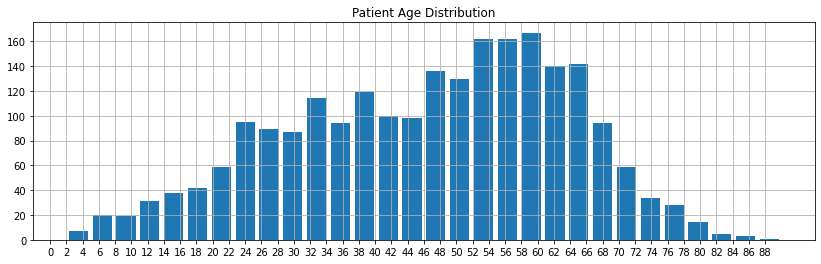

In [9]:
df1 = train_data[all_xray_df["Patient Age"]<100]
plt.figure(figsize=(14,4))
df1["Patient Age"].hist(rwidth=0.8, bins=30)
plt.xticks(range(0, np.max(df1['Patient Age']), 2))
plt.title('Patient Age Distribution')

In [10]:
train_data['pneumonia_class'].value_counts()

Positive    1145
Negative    1145
Name: pneumonia_class, dtype: int64

In [12]:
val_data['pneumonia_class'].value_counts()

Negative    1144
Positive     286
Name: pneumonia_class, dtype: int64

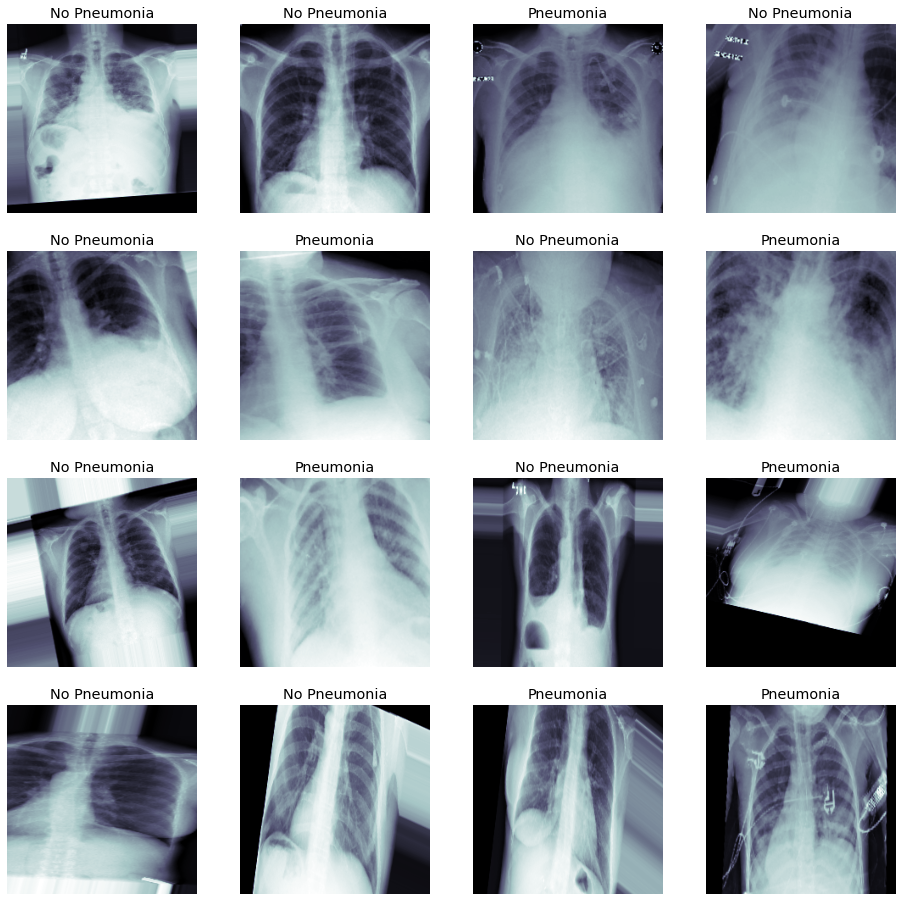

In [198]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [199]:
def load_pretrained_model():
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    # Todo
    ## Here, we'll freeze all but the 2 last convolutional layer
    for layer in vgg_model.layers[0:-2]:
        layer.trainable = False
      
    return vgg_model


In [200]:
def build_my_model():
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    vgg_model = load_pretrained_model()
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1, activation='sigmoid'))
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [201]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
weight_path="{}_my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor =  "val_loss", 
                             verbose=1, 
                             save_best_only=True, 
                             mode= "auto", 
                             save_weights_only = True)

early = EarlyStopping(monitor= "val_loss", 
                      mode= "auto", 
                      patience=10)

callbacks_list = [checkpoint, early]

In [202]:
my_model = build_my_model()
my_model.compile(optimizer=optimizer, 
                 loss=loss, 
                 metrics=['binary_accuracy'])

### Start training! 

In [219]:
## train your model
# Todo
history = my_model.fit_generator(train_gen, 
                          validation_data = val_gen, 
                          epochs = 30, 
                          callbacks = callbacks_list)

Epoch 1/30
18/18 [==============================] - 76s 4s/step - loss: 0.6629 - binary_accuracy: 0.6066 - val_loss: 0.5521 - val_binary_accuracy: 0.7224

Epoch 00001: val_loss improved from 0.57258 to 0.55205, saving model to xray_class_my_model.best.hdf5
Epoch 2/30
18/18 [==============================] - 64s 4s/step - loss: 0.6524 - binary_accuracy: 0.6162 - val_loss: 0.6094 - val_binary_accuracy: 0.6070

Epoch 00002: val_loss did not improve from 0.55205
Epoch 3/30
18/18 [==============================] - 64s 4s/step - loss: 0.6543 - binary_accuracy: 0.6162 - val_loss: 0.5450 - val_binary_accuracy: 0.6874

Epoch 00003: val_loss improved from 0.55205 to 0.54502, saving model to xray_class_my_model.best.hdf5
Epoch 4/30
18/18 [==============================] - 64s 4s/step - loss: 0.6482 - binary_accuracy: 0.6245 - val_loss: 0.6470 - val_binary_accuracy: 0.6420

Epoch 00004: val_loss did not improve from 0.54502
Epoch 5/30
18/18 [==============================] - 63s 4s/step - loss: 0.

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [233]:
## After training, make some predictions to assess your model's overall performance
## Note that detecting pneumonia is hard even for trained expert radiologists, 
## so there is no need to make the model perfect.
my_model.load_weights(weight_path)

# valX, valY = val_gen.next()
# Here, I reset val_gen in order to get prediction over all val_set
val_gen.reset()
pred_Y = my_model.predict(val_gen, verbose = True)

12/12 [==============================] - 24s 2s/step


In [234]:
# pred_Y.ravel()

In [235]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    fpr, tpr, thresholds = metrics.roc_curve(t_y, p_y, pos_label = 1)
    plt.plot(fpr,tpr)
    plt.style.use('ggplot')
    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.show()

## what other performance statistics do you want to include here besides AUC? 

def calc_f1(prec,recall):
    return 2*(prec*recall)/(prec+recall)
# Todo

def plot_Precision_Recall(t_y,p_y):
    precision, recall, thresholds = metrics.precision_recall_curve(t_y, p_y, pos_label = 1)
    plt.style.use('ggplot')
    plt.plot(precision, recall)
    plt.title('Precision-Recall Curve')
    plt.xlabel('Precision')
    plt.ylabel('Recall')

    plt.show()
    
def plot_f1(t_y,p_y):
    prec, recall, thresholds = metrics.precision_recall_curve(t_y, p_y, pos_label = 1)
    f1_scores = calc_f1(prec,recall)
    plt.style.use('ggplot')
    plt.plot( thresholds, f1_scores[0:len(thresholds)])
    plt.title('F1- Thresholds Curve')
    plt.xlabel('Thresholds')
    plt.ylabel('F1 Scores')

    plt.show()

    
#Also consider plotting the history of your model training:
def plot_history(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    return

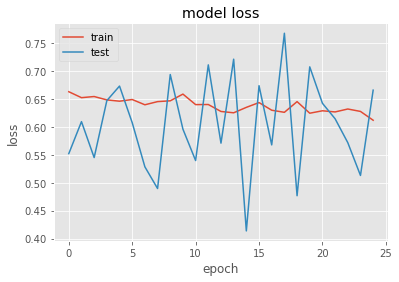

In [236]:
## plot figures
plot_history(history)
# Todo


In [237]:
np.shape(pred_Y.ravel()), np.shape(val_gen.labels)

((1430,), (1430,))

In [238]:
# val_gen.labels

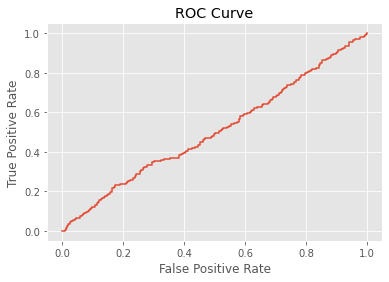

In [239]:
plot_auc(val_gen.labels, pred_Y.ravel())

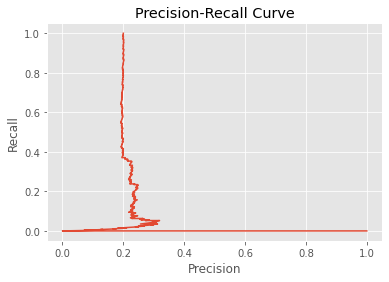

In [240]:
plot_Precision_Recall(val_gen.labels, pred_Y.ravel())

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide


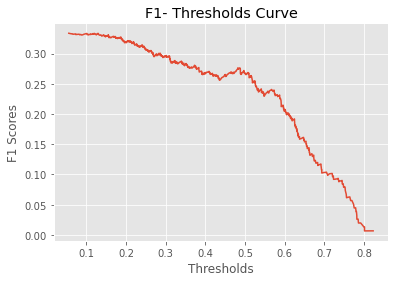

In [241]:
plot_f1(val_gen.labels, pred_Y.ravel())

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [242]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

def cal_stat(t_y, p_y, threshold):
    recall   = metrics.recall_score(t_y, p_y)
    precision= metrics.precision_score(t_y, p_y)
    accuracy = metrics.accuracy_score(t_y, p_y)
    f1_score = calc_f1(precision,recall)


    return [threshold, precision, recall, f1_score, accuracy]


statistics = []

for threshold in np.arange(0.0, 1.0, 0.05):
    pred_Y_ = (pred_Y.ravel() >= threshold)
    statistics.append(cal_stat(val_gen.labels, pred_Y_, threshold))

df = pd.DataFrame(statistics,
                     columns=['Threshold', 'Precision', 'Recall', 'F1_score', 'Accuracy'])

df
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Threshold,Precision,Recall,F1_score,Accuracy
0,0.00,0.200000,1.000000,0.333333,0.200000
1,0.05,0.200140,1.000000,0.333528,0.200699
2,0.10,0.200428,0.982517,0.332938,0.212587
3,0.15,0.200303,0.923077,0.329177,0.247552
4,0.20,0.197136,0.818182,0.317719,0.297203
5,0.25,0.196078,0.699301,0.306279,0.366434
6,0.30,0.197430,0.590909,0.295972,0.437762
7,0.35,0.196949,0.496503,0.282026,0.494406
8,0.40,0.196046,0.416084,0.266517,0.541958
9,0.45,0.206628,0.370629,0.265332,0.589510


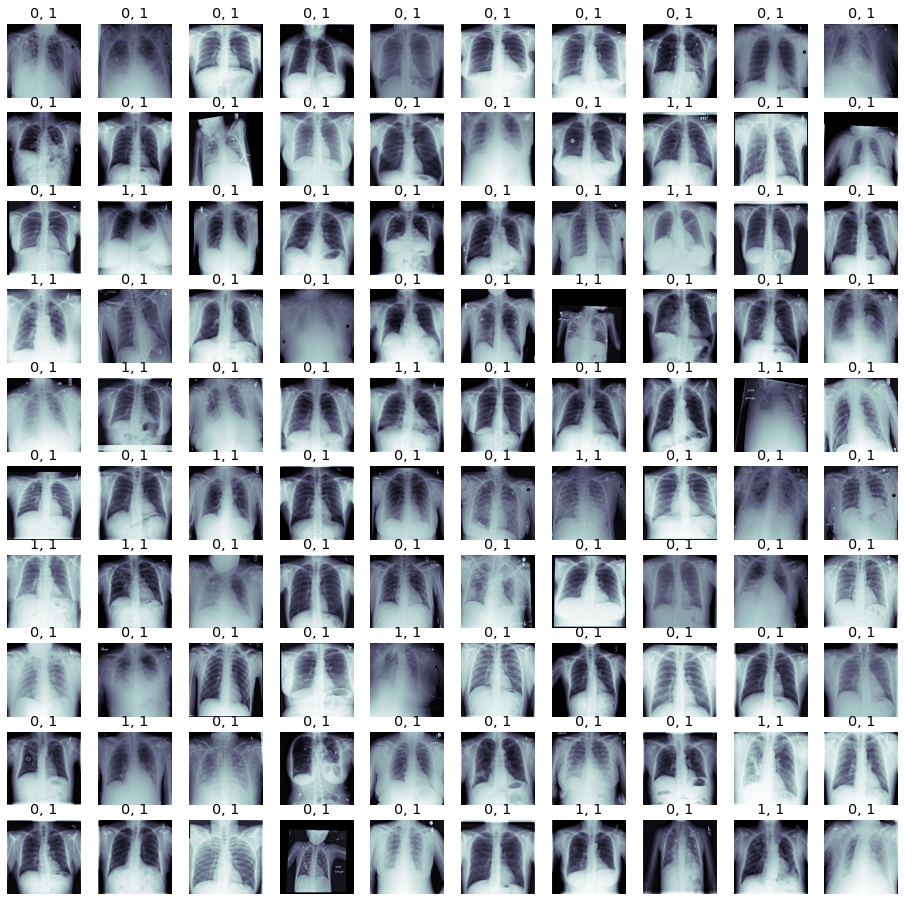

In [243]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo
F1_THRESHOLD = 0.015

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > F1_THRESHOLD:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > F1_THRESHOLD: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [244]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

In [245]:
my_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 2,384,897
Non-trainable params: 12,354,880
_________________________________________________________________
